<a href="https://colab.research.google.com/github/SophieD517/MTL/blob/main/Exponential%20Decay/ExponentialDecay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Objectives**
1.   Can multitask learning models make reasonably accurate predictions about the features of graphs when compared to conventional artificial neural networks?
2.   When trained using a multitask learning approach, are features of graphs directly encoded within the latent space?
3.   Does the number of variables in an equation correlate with the latent dimension that yields optimal reconstruction and predictions?



In [1]:
import numpy as np
import pandas as pd
import torch
import os
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader as dl
import math as m

# https://github.com/hcarlens/pytorch-tabular/blob/master/fast_tensor_data_loader.py
class FastTensorDataLoader:
    """
    A DataLoader-like object for a set of tensors that can be much faster than
    TensorDataset + DataLoader because dataloader grabs individual indices of
    the dataset and calls cat (slow).
    Source: https://discuss.pytorch.org/t/dataloader-much-slower-than-manual-batching/27014/6
    """
    def __init__(self, *tensors, batch_size=32, shuffle=False):
        """
        Initialize a FastTensorDataLoader.
        :param *tensors: tensors to store. Must have the same length @ dim 0.
        :param batch_size: batch size to load.
        :param shuffle: if True, shuffle the data *in-place* whenever an
            iterator is created out of this object.
        :returns: A FastTensorDataLoader.
        """
        assert all(t.shape[0] == tensors[0].shape[0] for t in tensors)
        self.tensors = tensors

        self.dataset_len = self.tensors[0].shape[0]
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Calculate # batches
        n_batches, remainder = divmod(self.dataset_len, self.batch_size)
        if remainder > 0:
            n_batches += 1
        self.n_batches = n_batches
    def __iter__(self):
        if self.shuffle:
            r = torch.randperm(self.dataset_len)
            self.tensors = [t[r] for t in self.tensors]
        self.i = 0
        return self

    def __next__(self):
        if self.i >= self.dataset_len:
            raise StopIteration
        batch = tuple(t[self.i:self.i+self.batch_size] for t in self.tensors)
        self.i += self.batch_size
        return batch

    def __len__(self):
        return self.n_batches

## Generate Data
Let us begin with some toy data. We have exponential decay curves created through the first-order decay equation  

  $N(t) = N_{0}e^{\frac{t}{t_{1/2}}}$

where $t_{1/2}$ represents the time required for half of the sample to decay. Below we illustrate the distribution of half-lives used as well as the graphs drawn as a function of $t$.

Since that each curve is dependent solely on the value of $t_{1/2}$, we can draw the assumption that a compressed representation of each curve should consist of only one data point, which should correspond directly to $t_{1/2}$.

In [2]:
half_lives = [np.random.uniform(low=1, high=10)*(10**np.random.uniform(low=-2, high=3)) for i in range(10000)]
rows = []
for half_life in half_lives:
  rows.append([0.5**(t/half_life) for t in range(100)])
data = pd.DataFrame(rows)
data['half_life'] = half_lives
data

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,half_life
0,1.0,0.001392,0.000002,2.698277e-09,3.756487e-12,5.229708e-15,7.280696e-18,1.013604e-20,1.411120e-23,1.964533e-26,...,1.192035e-260,1.659528e-263,2.310362e-266,3.216441e-269,4.477866e-272,6.233996e-275,8.678847e-278,1.208252e-280,1.682105e-283,0.105391
1,1.0,0.999572,0.999143,9.987151e-01,9.982872e-01,9.978594e-01,9.974319e-01,9.970045e-01,9.965773e-01,9.961503e-01,...,9.617508e-01,9.613387e-01,9.609268e-01,9.605151e-01,9.601035e-01,9.596922e-01,9.592809e-01,9.588699e-01,9.584591e-01,1617.348799
2,1.0,0.999416,0.998832,9.982485e-01,9.976653e-01,9.970825e-01,9.965000e-01,9.959179e-01,9.953361e-01,9.947546e-01,...,9.482126e-01,9.476587e-01,9.471051e-01,9.465518e-01,9.459989e-01,9.454462e-01,9.448939e-01,9.443419e-01,9.437902e-01,1186.170555
3,1.0,0.626003,0.391880,2.453183e-01,1.535700e-01,9.613535e-02,6.018105e-02,3.767353e-02,2.358376e-02,1.476351e-02,...,3.079445e-19,1.927743e-19,1.206773e-19,7.554442e-20,4.729105e-20,2.960436e-20,1.853242e-20,1.160136e-20,7.262489e-21,1.479820
4,1.0,0.980501,0.961382,9.426364e-01,9.242560e-01,9.062340e-01,8.885635e-01,8.712374e-01,8.542492e-01,8.375923e-01,...,1.666383e-01,1.633890e-01,1.602031e-01,1.570793e-01,1.540164e-01,1.510133e-01,1.480687e-01,1.451815e-01,1.423506e-01,35.200260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.0,0.940313,0.884189,8.314151e-01,7.817907e-01,7.351283e-01,6.912510e-01,6.499926e-01,6.111967e-01,5.747165e-01,...,3.696657e-03,3.476016e-03,3.268545e-03,3.073456e-03,2.890012e-03,2.717517e-03,2.555318e-03,2.402800e-03,2.259385e-03,11.262985
9996,1.0,0.999773,0.999546,9.993186e-01,9.990916e-01,9.988646e-01,9.986377e-01,9.984108e-01,9.981840e-01,9.979573e-01,...,9.795368e-01,9.793143e-01,9.790918e-01,9.788694e-01,9.786470e-01,9.784247e-01,9.782024e-01,9.779802e-01,9.777580e-01,3050.786272
9997,1.0,0.115181,0.013267,1.528075e-03,1.760055e-04,2.027252e-05,2.335012e-06,2.689495e-07,3.097792e-08,3.568073e-09,...,3.852292e-86,4.437116e-87,5.110722e-88,5.886590e-89,6.780244e-90,7.809565e-91,8.995150e-92,1.036072e-92,1.193360e-93,0.320716
9998,1.0,0.998861,0.997722,9.965856e-01,9.954500e-01,9.943158e-01,9.931828e-01,9.920512e-01,9.909208e-01,9.897917e-01,...,9.014527e-01,9.004256e-01,8.993996e-01,8.983748e-01,8.973511e-01,8.963287e-01,8.953074e-01,8.942872e-01,8.932682e-01,607.978793


In [3]:
def load_data():
  test = pd.read_csv('/content/test.csv').drop(columns='Unnamed: 0')
  train = pd.read_csv('/content/train.csv').drop(columns='Unnamed: 0')
  val = pd.read_csv('/content/validate.csv').drop(columns='Unnamed: 0')
  X = torch.tensor(train.drop(columns=['half_life']).values, requires_grad=True, dtype=torch.float32)
  Y = torch.tensor(train['half_life'].values, requires_grad=True, dtype=torch.float32).mul(0.001)
  X_test = torch.tensor(test.drop(columns=['half_life']).values, requires_grad=True, dtype=torch.float32)
  Y_test = torch.tensor(test['half_life'].values, requires_grad=True, dtype=torch.float32).mul(0.001)
  X_val = torch.tensor(val.drop(columns=['half_life']).values, requires_grad=True, dtype=torch.float32)
  Y_val = torch.tensor(val['half_life'].values, requires_grad=True, dtype=torch.float32).mul(0.001)
  return X, Y, X_test, Y_test, X_val, Y_val

[Text(0.5, 1.0, 'Half-life Distribution')]

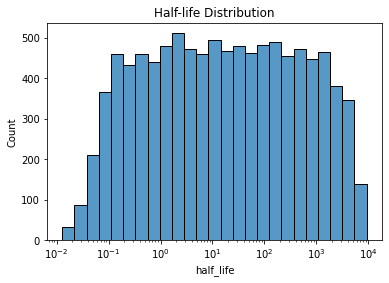

In [4]:
sns.histplot(data=data, x='half_life', bins=25, log_scale=True).set(title='Half-life Distribution')#, xlim=(10e-3, 10e2))

Text(0.5, 1.0, 'Fraction Substance Remaining Over Time')

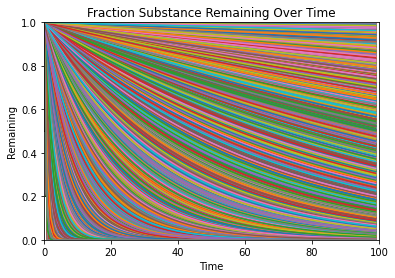

In [5]:
x = np.arange(100)
y = data.drop(columns=['half_life'])
for index, row in y.iterrows():
  plt.plot(x, row)
plt.ylabel('Remaining')
plt.xlabel('Time')
plt.ylim(0, 1)
plt.xlim(0, 100)
plt.title('Fraction Substance Remaining Over Time')

In [6]:
msk = np.random.rand(len(data)) < 0.8
train = data[msk]
test = data[~msk]
msk2 = np.random.rand(len(test)) < 0.8
validate = test[~msk2]
test = test[msk2]
train.to_csv('/content/train.csv')
test.to_csv('/content/test.csv')
validate.to_csv('/content/validate.csv')

#Neural Network

I begin with a series simple fully connected, linear layers to prove that $t_{1/2}$ is a discernible feature of the function $N(t)$. The input of the model are the curves shown above and the output is the half-life quantity.


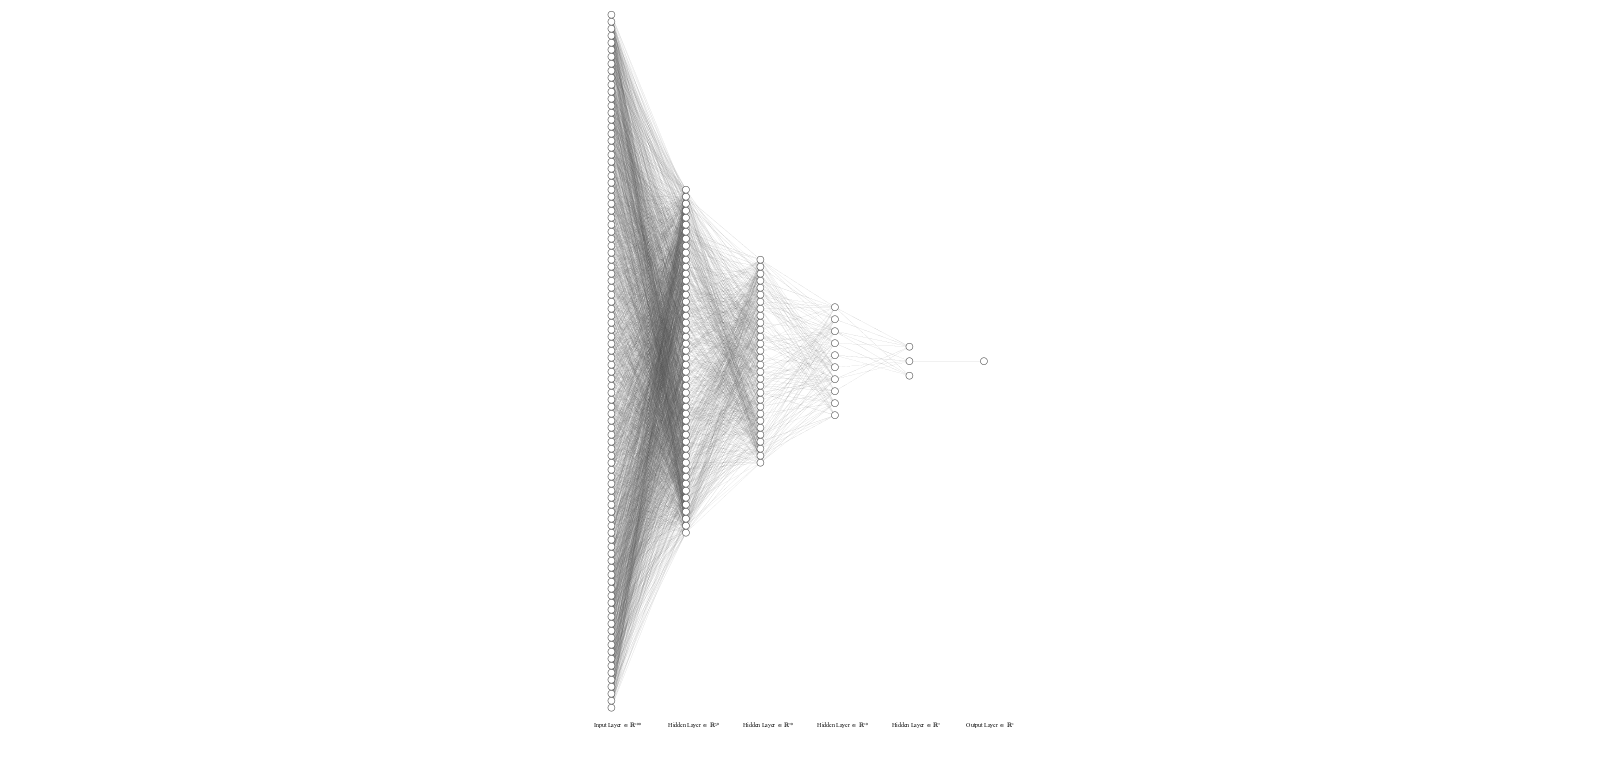

In [44]:
class NeuralNet(torch.nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.neural_net = torch.nn.Sequential(
            torch.nn.Linear(100, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 30),
            torch.nn.ReLU(),
            torch.nn.Linear(30, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 3),
            torch.nn.ReLU(),
            torch.nn.Linear(3, 1)
        )

    def forward(self, x):
        return self.neural_net(x)

In [52]:
model = NeuralNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
losses = []

def train(epochs, x, y, val_x, val_y):
  dataloader = FastTensorDataLoader(x, y, batch_size=128, shuffle=True)
  for epoch in range(epochs):
    for idx, data in enumerate(dataloader):
      optimizer.zero_grad()
      pred = model(data[0])
      loss = torch.nn.MSELoss()(pred.squeeze(), data[1].squeeze())
      losses.append(loss.detach().numpy())
      loss.backward(retain_graph=True)
      optimizer.step()
    print(f'loss: {loss}, val loss: {torch.nn.MSELoss()(model(val_x).squeeze(), val_y.squeeze())}')

def save():
  torch.save(model.state_dict(), 'nn.zip')

def graph_loss():
  plt.style.use('seaborn-whitegrid')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  x = np.arange(len(losses))
  y = losses
  plt.plot(x, y, color='purple')
  plt.xlim(0)
  plt.ylim(0)

def indiv_loss(xt, yt):
  losses = []
  df = test(xt, yt)
  preds = torch.tensor(df['predicted'])
  dataloader = FastTensorDataLoader(preds, yt, batch_size=1, shuffle=False)
  for idx, row in enumerate(dataloader):
    print(torch.nn.MSELoss()(row[0], row[1]).item())
    losses.append(torch.nn.MSELoss()(row[0], row[1]).item())
  return losses

def test(x_test, y_test):
  weights = torch.load('/content/nn.zip')
  model.load_state_dict(weights)
  model.eval()
  pred = model(x_test)
  loss = torch.nn.MSELoss()(pred.squeeze(), y_test.squeeze())
  test_df = pd.DataFrame({'half_life': y_test.detach().numpy()})
  test_df['predicted'] = [item for sublist in pred.tolist() for item in sublist]
  test_df['percent_error'] = 100*(test_df['predicted'] - test_df['half_life'])/test_df['half_life']
  return test_df

def loss_hist(xt, yt):
  fig, ax = plt.subplots()
  sns.histplot(data=indiv_loss(xt, yt), ax=ax)
  ax.set_xlim(0)
  plt.title('loss distribution')
  plt.show()

def graph_results(xt, yt, num=1000):
  plt.style.use('seaborn-whitegrid')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  sample_df = test(xt, yt).sample(n=num)
  y = sample_df['half_life'].apply(lambda x: x*1000)
  x = sample_df['predicted'].apply(lambda x: x*1000)
  plt.scatter(x, y, color='blue', s=.1)
  plt.plot(x, x, color='gray', linewidth=.3)
  plt.xlim(0, 1000)
  plt.ylim(0, 1000)

loss: 0.04581548646092415, val loss: 2.0823166370391846
loss: 0.4658759534358978, val loss: 1.2923285961151123
loss: 0.36623597145080566, val loss: 1.1742792129516602
loss: 0.26133784651756287, val loss: 1.0477800369262695
loss: 0.19279147684574127, val loss: 0.9085447788238525
loss: 0.048290666192770004, val loss: 0.8959906697273254
loss: 0.6160489916801453, val loss: 0.6671332120895386
loss: 0.0015752245672047138, val loss: 0.6812391877174377
loss: 0.0019148141145706177, val loss: 0.5158061385154724
loss: 0.00885856430977583, val loss: 0.46502402424812317
loss: 0.0003573755675461143, val loss: 0.5494586229324341
loss: 0.000509999634232372, val loss: 0.5996870398521423
loss: 0.2577592134475708, val loss: 0.3801061809062958
loss: 0.08062716573476791, val loss: 0.38506489992141724
loss: 0.07850300520658493, val loss: 0.40913355350494385
loss: 0.09446870535612106, val loss: 0.36964288353919983
loss: 0.00035022562951780856, val loss: 0.3727331757545471
loss: 0.0037428252398967743, val los

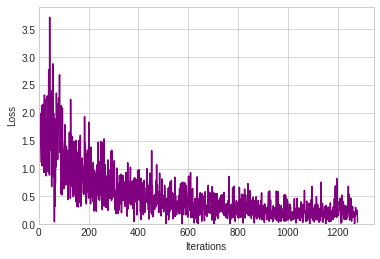

In [46]:
x, y, xt, yt, xv, yv = load_data()
train(20, x, y, xv, yv)
save()
graph_loss()

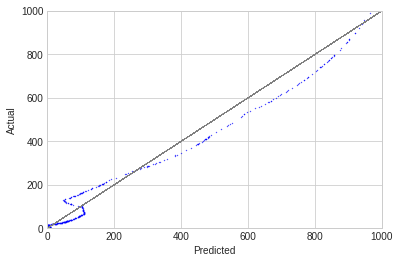

In [50]:
graph_results(xt, yt)

1.8760585455547505e-06
3.854819069008168e-06
1.8749224936970825e-06
2.2329982865023116e-05
0.005032438542427686
0.004912682718497763
5.515689096657894e-05
1.394297789821497e-05
0.0003741385308444478
0.0015969395028117006
0.000446066464472903
0.1554711612498636
0.0017076773530144834
0.0006390851189232993
2.0615341261605305e-06
0.0017812342211334653
0.003976336271737324
0.005091562626578006
2.1105873529349457e-06
3.181752268683127e-05
11.839445574933109
1.8600929215174205e-06
2.969145706182598e-06
2.0351131779707498e-06
2.541883167998167e-06
0.3198833102360368
2.016198121953934e-06
2.161599807136559e-06
2.5291474389772947e-05
0.0010123506698538898
0.009862223689708571
3.378528254053626e-06
1.8971806806289055e-06
0.3997250778639341
0.001620701588613882
1.6254293904182726e-05
2.4348634417581394e-06
0.0017378336570917363
3.4307947080742954e-05
0.01923670028105562
1.3872976102043003e-05
4.5837437878726295e-05
0.18427715875817796
0.0030724620511635714
0.003741460433559496
2.08958060537319e-06

KeyboardInterrupt: ignored

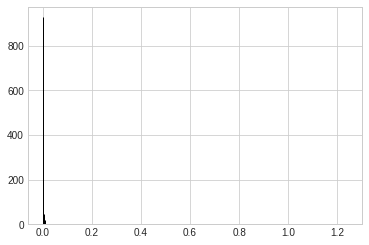

In [54]:
loss_hist(xt, yt)

# Autoencoder
Next, we attempt to perform dimensionality reduction on the dataset. Autoencoders consist of an encoder, a neural network that encodes data into the low-dimensional bottleneck layer, and a decoder, a mirror image of the encoder that reconstructs the curve from the bottleneck layer, otherwise known as the latent space. Typically, we represent this as a pair of transformations, 

$\phi:X\rightarrow F$

$\psi:F\rightarrow X'$

the composition of which is equal to 1. The goal of the autoencoder is to create a latent space, F, such that 

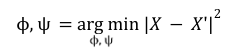

In [19]:
class AutoEncoder(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = torch.nn.Sequential(
      torch.nn.Linear(100, 70),
      torch.nn.ReLU(),
      torch.nn.Linear(70, 40),
      torch.nn.ReLU(),
      torch.nn.Linear(40, 20),
      torch.nn.ReLU(),
      torch.nn.Linear(20, 10),
      torch.nn.ReLU(),
      torch.nn.Linear(10, 2)
    )
    self.decoder = torch.nn.Sequential( 
      torch.nn.ReLU(),
      torch.nn.Linear(2, 10),
      torch.nn.ReLU(),
      torch.nn.Linear(10, 20),
      torch.nn.ReLU(),
      torch.nn.Linear(20, 40),
      torch.nn.ReLU(),
      torch.nn.Linear(40, 70),
      torch.nn.ReLU(),
      torch.nn.Linear(70, 100),
      torch.nn.Sigmoid()
    )

  def forward(self, x):
    latent_space = self.encoder(x)
    return self.decoder(latent_space)

In [20]:
model = AutoEncoder()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
losses = []

def train(epochs, x, val_x):
  dataloader = FastTensorDataLoader(x, shuffle=True)
  for epoch in range(epochs):
    for idx, data in enumerate(dataloader):
      optimizer.zero_grad()
      pred = model(data[0])
      loss = torch.nn.MSELoss()(pred.squeeze(), data[0].squeeze())
      losses.append(loss.detach().numpy())
      loss.backward(retain_graph=True)
      optimizer.step()
    print(f'loss: {loss}, val loss: {torch.nn.MSELoss()(model(val_x).squeeze(), val_x.squeeze())}')

def save():
  torch.save(model.state_dict(), '/content/ae.zip') 

def graph_loss():
  plt.style.use('seaborn-whitegrid')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  x = np.arange(len(losses))
  y = losses
  plt.plot(x, y)
  plt.xlim(0)
  plt.ylim(0)

def test(xt):
  weights = torch.load('/content/ae.zip')
  model.load_state_dict(weights)
  model.eval()
  pred = model(xt)
  loss = torch.nn.MSELoss()(pred, xt).detach().numpy()
  return loss, pred.detach().numpy()

def graph_recon(xt):
  color = []
  for i in range(2000):
      color.append('#%06X' % np.random.randint(0, 0xFFFFFF))

  loss, recon = test(xt)
  plt.style.use('seaborn-whitegrid')
  figs, axs = plt.subplots(1, 2)
  axs[0].set(xlim=(0, 100), ylim=(0, 1), title='Original', xlabel='time', ylabel='sample remaining')
  axs[1].set(xlim=(0, 100), ylim=(0, 1), title='Reconstructed', xlabel='time', ylabel='sample remaining')
  x = np.linspace(0, 100, 100, endpoint=False)
  for i in np.random.randint(0, high=1000, size=200):
    axs[0].plot(x, xt.detach().numpy()[i], color=color[i])
  for i in np.random.randint(0, high=1000, size=200):
    axs[1].plot(x, recon[i], color=color[i])

loss: 0.00027497109840624034, val loss: 0.004542705602943897
loss: 7.175328937591985e-05, val loss: 0.00026664664619602263
loss: 0.00015769069432280958, val loss: 0.00013678104733116925
loss: 6.670279617537744e-06, val loss: 3.8612975913565606e-05
loss: 8.33102694741683e-06, val loss: 2.585815491329413e-05
loss: 1.19482074296684e-05, val loss: 2.2817936041974463e-05
loss: 1.5729649021523073e-05, val loss: 1.1869870832015295e-05
loss: 1.2906813935842365e-05, val loss: 2.2682010239805095e-05
loss: 1.7047022993210703e-05, val loss: 1.3053129805484787e-05
loss: 4.790926141140517e-06, val loss: 1.2058655556757003e-05


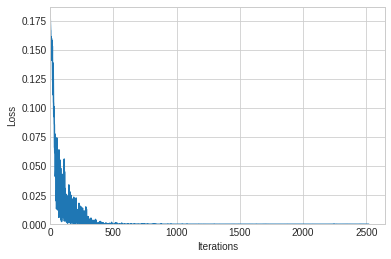

In [21]:
x, y, xt, yt, xv, yv = load_data()
train(10, x, xv)
save()
graph_loss()

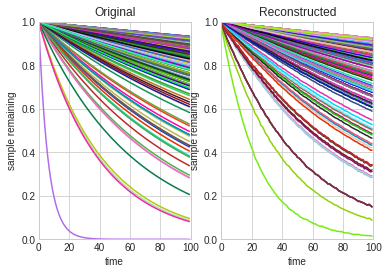

In [22]:
graph_recon(xt)

# Multitask Learning
Combining the objectives of the neural network and autoencoder, we arrive at multitask learning model involving an autoencoder and a single branch as illustrated below. The normalization of data was especially important in this stage to prevent the model from prioritizing either task. Weighting of the two losses, as shown by the variable $m$ below, can also aid the model in balancing both tasks.

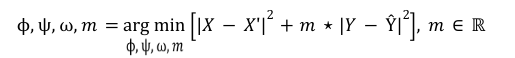

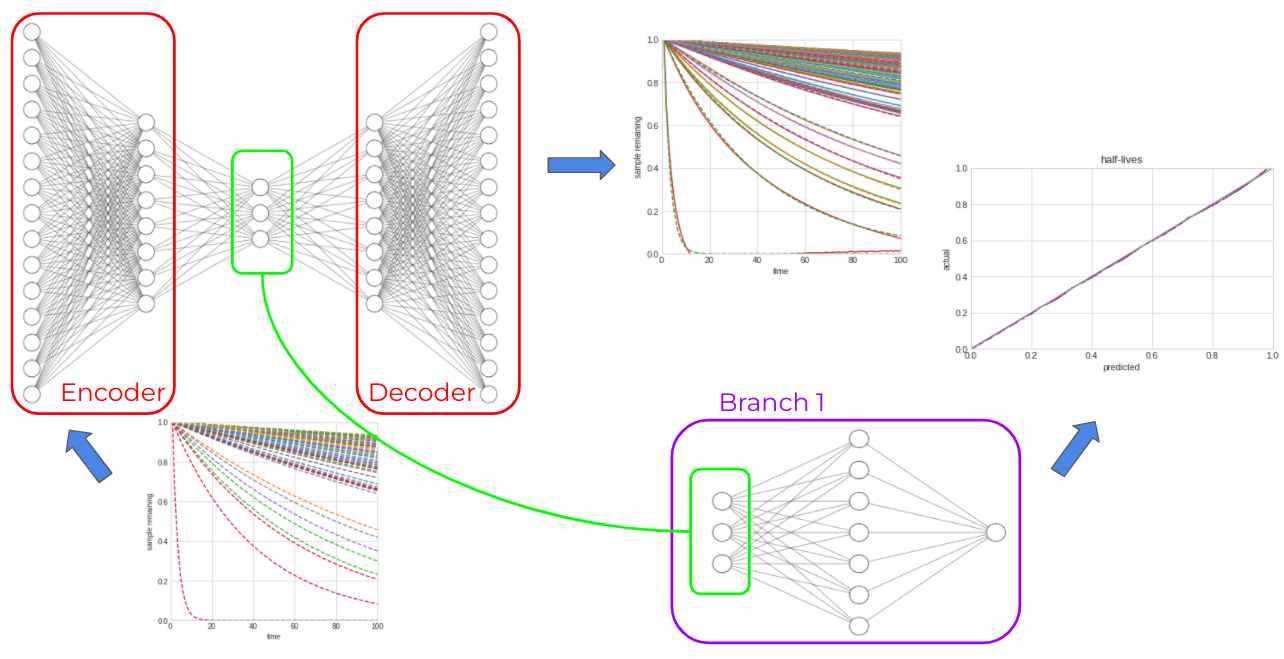

In [7]:
class Bear(torch.nn.Module):
  def __init__(self, latent_dim, ae_layer, branch1_layer):
    super().__init__()
    self.encoder = torch.nn.Sequential( 
      torch.nn.Linear(100, ae_layer),
      torch.nn.ReLU(),
      torch.nn.Linear(ae_layer, latent_dim)
    )
    self.decoder = torch.nn.Sequential( 
      torch.nn.ReLU(),
      torch.nn.Linear(latent_dim, ae_layer),
      torch.nn.ReLU(),
      torch.nn.Linear(ae_layer, 100)
    )
    self.branch1 = torch.nn.Sequential(
      torch.nn.ReLU(),
      torch.nn.Linear(latent_dim, branch1_layer),
      torch.nn.ReLU(),
      torch.nn.Linear(branch1_layer, 1)
    )

  def forward(self, x):
    latent_space = self.encoder(x)
    return latent_space, self.decoder(latent_space), self.branch1(latent_space)

In [8]:
model = Bear(3, 20, 10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
losses = []

def train_step(x, y):
  optimizer.zero_grad()
  ls, recon, pred = model(x)
  recon_loss = torch.nn.MSELoss()(recon.squeeze(), x.squeeze())
  pred_loss = torch.nn.MSELoss()(pred.squeeze(), y.squeeze())
  loss = 2*recon_loss + pred_loss
  losses.append(loss.detach().numpy())
  loss.backward(retain_graph=True)
  optimizer.step()
  return loss

def val_step(x, y):
  ls, recon, pred = model(x)
  recon_loss = torch.nn.MSELoss()(recon.squeeze(), x.squeeze())
  pred_loss = torch.nn.MSELoss()(pred.squeeze(), y.squeeze())
  loss = 2*recon_loss.detach().numpy() + pred_loss.detach().numpy()
  return loss

def train(epochs, x, y, val_x, val_y):
  dataloader = FastTensorDataLoader(x, y, batch_size=64, shuffle=True)
  for epoch in range(epochs):
    for idx, data in enumerate(dataloader):
      loss = train_step(data[0], data[1])
    print(f'loss: {loss}, val loss: {val_step(val_x, val_y)}')

def graph_loss():
  plt.style.use('seaborn-whitegrid')
  plt.xlabel('Iterations')
  x = np.arange(0, len(losses))
  y = losses 
  plt.plot(x, y, color='blue', linewidth=0.5)
  plt.ylim(0)
  plt.xlim(0)
  plt.show()

def save():
  torch.save(model.state_dict(), 'model.zip')

def indiv_loss(xt, yt):
  losses = []
  weights = torch.load('/content/model.zip')
  model.load_state_dict(weights)
  model.eval()
  ls, recon, preds = model(xt)
  dataloader = FastTensorDataLoader(preds, yt, recon, xt, batch_size=1, shuffle=False)
  for idx, row in enumerate(dataloader):
    loss = torch.nn.MSELoss()(row[0].squeeze(), row[1].squeeze()).item() + 2*torch.nn.MSELoss()(row[2].squeeze(), row[3].squeeze()).item()
    losses.append(loss)
  return losses

def loss_hist(xt, yt):
  fig, ax = plt.subplots()
  sns.histplot(data=indiv_loss(xt, yt), ax=ax, bins=50)
  ax.set_xlim(0)
  plt.title('loss distribution')
  plt.show()

def graph_results(xt, yt, num=1000):
  plt.style.use('seaborn-whitegrid')
  plt.xlabel('Actual')
  plt.ylabel('Predict')
  losses = []
  weights = torch.load('/content/model.zip')
  model.load_state_dict(weights)
  model.eval()
  ls, recon, preds = model(xt)
  y = [i*1000 for i in preds.detach().numpy()]
  x = [i*1000 for i in yt.detach().numpy()]
  plt.scatter(x, y, color='blue', s=.1)
  plt.plot(x, x, color='gray', linewidth=.3)
  plt.xlim(0, 1000)
  plt.ylim(0, 1000)

def graph_recon(xt):
  color = []
  for i in range(2000):
      color.append('#%06X' % np.random.randint(0, 0xFFFFFF))
  ls, recon, preds = model(xt)
  plt.style.use('seaborn-whitegrid')
  figs, axs = plt.subplots(1, 2)
  axs[0].set(xlim=(0, 100), ylim=(0, 1), title='Original', xlabel='time', ylabel='sample remaining')
  axs[1].set(xlim=(0, 100), ylim=(0, 1), title='Reconstructed', xlabel='time', ylabel='sample remaining')
  x = np.linspace(0, 100, 100, endpoint=False)
  for i in np.random.randint(0, high=1000, size=200):
    axs[0].plot(x, xt.detach().numpy()[i], color=color[i])
  for i in np.random.randint(0, high=1000, size=200):
    axs[1].plot(x, recon.detach().numpy()[i], color=color[i])

loss: 1.278810977935791, val loss: 1.0097888223826885
loss: 0.32070374488830566, val loss: 0.9179212152957916
loss: 1.5203574895858765, val loss: 0.8641522824764252
loss: 0.14490124583244324, val loss: 0.7916439734399319
loss: 0.5345327258110046, val loss: 0.709238613024354
loss: 0.4534139633178711, val loss: 0.6433545718900859
loss: 0.5293256044387817, val loss: 0.5740876873023808
loss: 0.4568668305873871, val loss: 0.5198579679708928
loss: 0.29910558462142944, val loss: 0.4902948250528425
loss: 0.8348754048347473, val loss: 0.41622992721386254
loss: 0.445971816778183, val loss: 0.37914783658925444
loss: 0.298144668340683, val loss: 0.3438843354815617
loss: 0.07691537588834763, val loss: 0.3051029777270742
loss: 0.4166862368583679, val loss: 0.2669142591767013
loss: 0.23440200090408325, val loss: 0.25190923654008657
loss: 0.13687877357006073, val loss: 0.23194972414057702
loss: 0.41665396094322205, val loss: 0.2778923839214258
loss: 1.1116491556167603, val loss: 0.1875734647619538
los

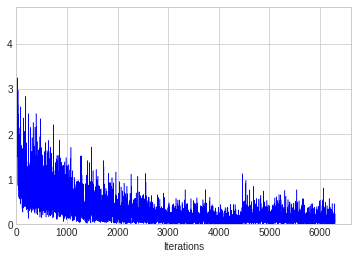

In [9]:
x, y, xt, yt, xv, yv = load_data()
train(50, x, y, xv, yv)
save()
graph_loss()

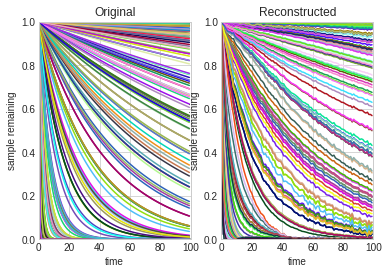

In [10]:
graph_recon(xt)

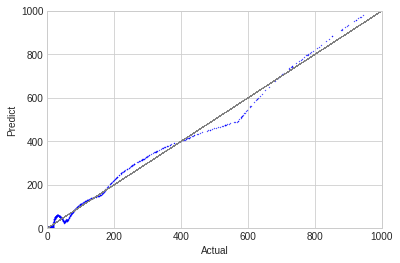

In [11]:
graph_results(xt, yt)

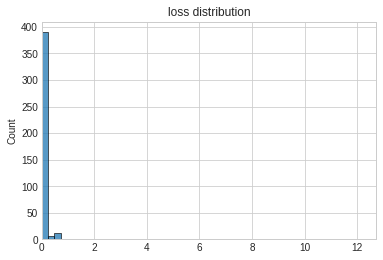

In [12]:
loss_hist(xv, yv)